In [1]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PolySineBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class QuadrotorTrajectoryOutput(ConfigurationDynamics):
    def __init__(self, bilinear_dynamics, y_d, y_d_dot, y_d_ddot, dt, z_d=None, z_d_dot=None, z_d_ddot=None, C_h=None):
        ConfigurationDynamics.__init__(self, bilinear_dynamics, 2)
        self.bilinear_dynamics = bilinear_dynamics
        self.ref = y_d
        self.ref_dot = y_d_dot
        self.ref_ddot = y_d_ddot

        self.ref_z = z_d
        self.ref_dot_z = z_d_dot
        self.ref_ddot_z = z_d_ddot

        self.C_h = C_h
        self.dt = dt
        self.t_d = self.dt * np.arange(0, self.ref.shape[1])

    def eval_z(self, x, t):
        z = self.bilinear_dynamics.phi_fun(x.reshape(1,-1)).squeeze()
        return z - self.z_d(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.array([[1, 0], [0, 1]])

    def d2ydq2(self, q):
        return np.zeros((1, 2, 2))

    def y_d(self, t):
        return self.interpolate_ref_(self.ref, t)

    def y_d_dot(self, t):
        return self.interpolate_ref_(self.ref_dot, t)

    def y_d_ddot(self, t):
        return self.interpolate_ref_(self.ref_ddot, t)

    def z_d(self, t):
        return self.interpolate_ref_(self.ref_z, t)

    def z_d_dot(self, t):
        return self.interpolate_ref_(self.ref_dot_z, t)

    def z_d_ddot(self, t):
        return self.interpolate_ref_(self.ref_ddot_z, t)

    def interpolate_ref_(self, ref, t):
        return np.array([np.interp(t, self.t_d, ref[ii, :]) for ii in range(ref.shape[0])])

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
# Cart pole system parameters
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 1e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A=A_nom, B=B_nom, C=np.eye(n), basis = lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 50                                                      # Number of trajectories to execute, data collection
noise_var = 1.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([50., 50.]) - hover_thrust                          # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 5                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot

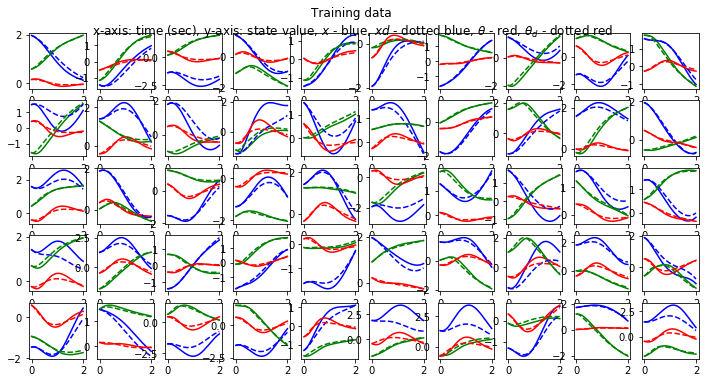

In [4]:
xd = np.empty((n_traj_dc, n_pred_dc + 1, n))
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd[ii, :, :] = mpc_trajgen.parse_result().T
    while abs(x0[0]) < 1.25 or np.any(np.isnan(xd[ii, :, :])):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
    xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
    plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
    plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
    plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
    plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
    y=0.94)
plt.show()

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [5]:
#DMD parameters:
alpha_dmd = 1.4e-2                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [6]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_dc, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False)
xdmd, y_dmd = model_dmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [7]:
#EDMD parameters:
alpha_edmd = 1.1e-1                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [8]:
basis = PolySineBasis(n, poly_deg=2, cross_terms=False)
basis.construct_basis()
poly_sine_features = preprocessing.FunctionTransformer(basis.basis)
poly_sine_features.fit(np.zeros((1,n)))
n_lift_edmd = poly_sine_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random')
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_dc, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd)
X_edmd, y_edmd = model_edmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
model_edmd.reduce_mdl()
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis_reduced)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [9]:
#Bilinear EDMD parameters:
alpha_bedmd_init = 1.9e-2                                           # Regularization strength (LASSO) bEDMD
alpha_bedmd = 1.9e-2
tune_mdl_bedmd = False

In [10]:
n_lift_bedmd = n_lift_edmd
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: poly_sine_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd)
X_bedmd, y_bedmd = model_bedmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    

/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1790: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370.434670698075, tolerance: 36.56953650773388
  check_random_state(self.random_state), random)


### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [11]:
# Prediction performance evaluation parameters:
folder_plots = 'examples/figures/'                                  # Path to save plots
n_traj_ol = 100                                                      # Number of trajectories to execute, open loop

In [12]:
xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_dmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_edmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=mass * gravity / 2)

    xs_ol[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:]-hover_thrust, t_eval[:-1])

    xs_dmd_ol[ii,:,:], _ = sys_dmd.simulate(x0, ol_controller_nom, t_eval[:-1])

    z_0_edmd = sys_edmd.basis(np.atleast_2d(x0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ol_controller_nom, t_eval[:-1])
    xs_edmd_ol[ii,:,:] = np.dot(model_edmd.C, zs_edmd_tmp.T).T

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T

error_dmd = xs_ol[:,:-1,:] - xs_dmd_ol
error_dmd_mean = np.mean(error_dmd, axis=0).T
error_dmd_std = np.std(error_dmd, axis=0).T
mse_dmd = np.mean(np.mean(np.mean(np.square(error_dmd))))

error_edmd = xs_ol[:,:-1,:] - xs_edmd_ol
error_edmd_mean = np.mean(error_edmd, axis=0).T
error_edmd_std = np.std(error_edmd, axis=0).T
mse_edmd = np.mean(np.mean(np.mean(np.square(error_edmd))))

error_bedmd = xs_ol[:,:-1,:] - xs_bedmd_ol
error_bedmd_mean = np.mean(error_bedmd, axis=0).T
error_bedmd_std = np.std(error_bedmd, axis=0).T
mse_bedmd = np.mean(np.mean(np.mean(np.square(error_bedmd))))

print('\nOpen loop performance statistics:')
print('   MSE DMD:   ', "{:.3f}".format(mse_dmd),
      '\n   MSE EDMD:  ', "{:.3f}".format(mse_edmd),
      '\n   MSE bEDMD: ', "{:.3f}".format(mse_bedmd))
print('   Improvement DMD -> EDMD:   ', "{:.2f}".format((1 - mse_edmd / mse_dmd) * 100), ' %'
      '\n   Improvement DMD -> bEDMD:  ', "{:.2f}".format((1 - mse_bedmd / mse_dmd) * 100), ' %'
      '\n   Improvement EDMD -> bEDMD: ', "{:.2f}".format((1 - mse_bedmd / mse_edmd) * 100), ' %')


Open loop performance statistics:
   MSE DMD:    18.290 
   MSE EDMD:   9.704 
   MSE bEDMD:  7.446
   Improvement DMD -> EDMD:    46.94  %
   Improvement DMD -> bEDMD:   59.29  %
   Improvement EDMD -> bEDMD:  23.27  %


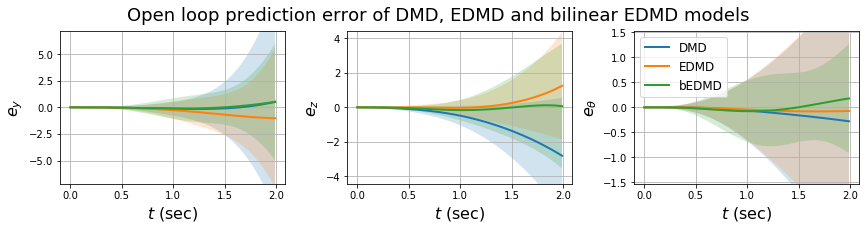

In [13]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 16
y_lim_gain = 1.2

#Plot open loop results:
ylabels = ['$e_{y}$', '$e_z$', '$e_{\\theta}$']
plt.figure(figsize=(figwidth,3))
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(t_eval[:-1], error_dmd_mean[ii,:], linewidth=lw, label='DMD')
    plt.fill_between(t_eval[:-1], error_dmd_mean[ii,:] - error_dmd_std[ii,:], error_dmd_mean[ii,:] + error_dmd_std[ii,:], alpha=0.2)
    plt.plot(t_eval[:-1], error_edmd_mean[ii, :], linewidth=lw, label='EDMD')
    plt.fill_between(t_eval[:-1], error_edmd_mean[ii, :] - error_edmd_std[ii, :],error_edmd_mean[ii, :] + error_edmd_std[ii, :], alpha=0.2)
    plt.plot(t_eval[:-1], error_bedmd_mean[ii, :], linewidth=lw, label='bEDMD')
    plt.fill_between(t_eval[:-1], error_bedmd_mean[ii, :] - error_bedmd_std[ii, :],error_bedmd_mean[ii, :] + error_bedmd_std[ii, :], alpha=0.2)
    ylim = max(max(np.abs(error_bedmd_mean[ii, :] - error_bedmd_std[ii, :])), max(np.abs(error_bedmd_mean[ii, :] + error_bedmd_std[ii, :])))
    plt.ylim([-ylim * y_lim_gain, ylim * y_lim_gain])
    plt.xlabel('$t$ (sec)', fontsize=fs)
    plt.ylabel(ylabels[ii], fontsize=fs)
    plt.grid()

plt.legend(loc='upper left', fontsize=fs-4)
suptitle = plt.suptitle('Open loop prediction error of DMD, EDMD and bilinear EDMD models', y=1.05, fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()


### Evaluate closed loop performance

We now study the closed loop performance of the control design. A trajectory is designed
to move the system from $(y_0,z_0) = (-1,0)$ to $(y_f,z_f) = (1,1)$. Then, the feedback linearizing controller is
designed to track the trajectory in the $z,\theta$ coordinates. These coordinates are chosen to avoid singularities
present in the $y,z$ coordinates. Comparing the closed loop performance of the feedback linearization based on the
bEDMD with LQR controllers designed using the DMD and EDMD models, we observe that the trajectory tracking error is
significantly reduced while expending only somewhat more control effort.

In [14]:
#Closed loop performance evaluation parameters:
x0_cl = np.array([-1., 0., 0., 0., 0., 0.])                         # Initial value, closed loop trajectory
set_pt_cl = np.array([1., 1., 0., 0., 0., 0.])                      # Desired final value, closed loop trajectory
t_eval_cl = dt * np.arange(201)                                     # Simulation time points, closed loop
Q_trajgen_cl = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
QN_trajgen_cl = sc.sparse.diags([3e2,3e2,3e2,1e2,1e2,1e2])          # Final state penalty matrix, trajectory generation
R_trajgen_cl = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation
mpc_trajgen_cl = MPCController(nominal_sys,t_eval_cl.size,dt,umin,umax,xmin,xmax,QN_trajgen_cl,R_trajgen_cl,QN_trajgen_cl,set_pt_cl)
q_cl, r_cl = 2e1, 1                                                  # State and actuation penalty values, closed loop
output_inds = np.array([1, 2])                                      # Output states, feedback linearizing controller

# Generate trajectory:
mpc_trajgen_cl.eval(x0_cl, 0)
xr_cl = mpc_trajgen_cl.parse_result()[:,:-1]
ur_cl = mpc_trajgen_cl.get_control_prediction()
xr_cl_dot = nominal_sys.eval_dot(xr_cl,ur_cl,0.)

# Define outputs:
y_d = xr_cl[output_inds,:]
y_d_dot = xr_cl[output_inds+int(n/2),:]
y_d_ddot = xr_cl_dot[output_inds+int(n/2),:]

##### Design LQR controller based on DMD model

In [15]:
Q_dmd = q_cl*np.identity(n)
R_dmd = r_cl*np.identity(m)
P_dmd = sc.linalg.solve_continuous_are(model_dmd.A, model_dmd.B, Q_dmd, R_dmd)
K_dmd = np.linalg.inv(R_dmd)@model_dmd.B.T@P_dmd
K_dmd_p, K_dmd_d = K_dmd[:,:int(n/2)], K_dmd[:,int(n/2):]
output_dmd = QuadrotorPdOutput(sys_dmd, xr_cl.T, t_eval_cl, n, m)
controller_dmd = PDController(output_dmd, K_dmd_p, K_dmd_d)
controller_dmd = PerturbedController(sys_dmd,controller_dmd,0.,const_offset=hover_thrust, umin=umin, umax=umax)

##### Design LQR controller based on EDMD model

In [16]:
z_d_edmd = np.array([sys_edmd.basis(x.reshape(1,-1)).squeeze() for x in xr_cl.T]).T
z_d_dot_edmd = differentiate_vec(z_d_edmd.T, t_eval_cl).T
z_d_ddot_edmd = differentiate_vec(z_d_dot_edmd.T, t_eval_cl).T
output_edmd = QuadrotorTrajectoryOutput(sys_edmd, y_d, y_d_dot, y_d_ddot, dt, z_d_edmd, z_d_dot_edmd, z_d_ddot_edmd, model_edmd.C[output_inds,:])

Q_edmd = q_cl*np.identity(sys_edmd.n)
R_edmd = r_cl*np.identity(m)
P_edmd = sc.linalg.solve_continuous_are(sys_edmd.A, sys_edmd.B, Q_edmd, R_edmd)
K_edmd = np.linalg.inv(R_edmd)@model_edmd.B.T@P_edmd
controller_edmd = LinearLiftedController(output_edmd, K_edmd)
controller_edmd = PerturbedController(quadrotor, controller_edmd,0.,const_offset=hover_thrust, umin=umin, umax=umax)


LinAlgError: Failed to find a finite solution.

##### Design feedback linearizing controller based on bEDMD model

In [ ]:
k = m
n_lift_bedmd = sys_bedmd.n
Q_bedmd = q_cl*np.eye(int(2*n_lift_bedmd))
R_bedmd = r_cl*np.eye(n_lift_bedmd)
C_h = model_bedmd.C[output_inds,:]

z_d_bedmd = np.array([sys_bedmd.basis(x.reshape(1,-1)).squeeze() for x in xr_cl.T]).T
z_d_dot_bedmd = differentiate_vec(z_d_bedmd.T, t_eval_cl).T
z_d_ddot_bedmd = differentiate_vec(z_d_dot_bedmd.T, t_eval_cl).T
output_bedmd = QuadrotorTrajectoryOutput(sys_bedmd, y_d, y_d_dot, y_d_ddot, dt, z_d_bedmd, z_d_dot_bedmd, z_d_ddot_bedmd, C_h)

f_eta = np.concatenate((np.zeros((n_lift_bedmd,n_lift_bedmd)), np.eye(n_lift_bedmd)), axis=1)
f_eta_dot = np.concatenate((sys_bedmd.F@sys_bedmd.F, np.zeros((n_lift_bedmd,n_lift_bedmd))), axis=1)
F_lin = np.concatenate((f_eta, f_eta_dot), axis=0)
G_lin = np.concatenate((np.zeros((n_lift_bedmd,n_lift_bedmd)), np.eye(n_lift_bedmd)), axis=0)

P_bedmd = sc.linalg.solve_continuous_are(F_lin, G_lin, Q_bedmd, R_bedmd)
K_bedmd = np.linalg.inv(R_bedmd)@G_lin.T@P_bedmd
controller_bedmd = BilinearFBLinController(sys_bedmd, output_bedmd, K_bedmd)
controller_bedmd = PerturbedController(sys_bedmd, controller_bedmd,0.,const_offset=hover_thrust, umin=umin, umax=umax)


##### Compare closed loop performance

In [ ]:
# Simulate the system under closed loop control:
xs_cl_dmd, us_cl_dmd = quadrotor.simulate(x0_cl, controller_dmd, t_eval_cl)
xs_cl_edmd, us_cl_edmd = quadrotor.simulate(x0_cl, controller_edmd, t_eval_cl)
xs_cl_bedmd, us_cl_bedmd = quadrotor.simulate(x0_cl, controller_bedmd, t_eval_cl)

mse_cl_dmd = np.linalg.norm(xs_cl_dmd[1:,output_inds]-xr_cl[output_inds,1:].T, ord='fro')**2
mse_cl_edmd = np.linalg.norm(xs_cl_edmd[1:,output_inds]-xr_cl[output_inds,1:].T, ord='fro')**2
mse_cl_bedmd = np.linalg.norm(xs_cl_bedmd[1:,output_inds]-xr_cl[output_inds,1:].T, ord='fro')**2
ctrl_cost_dmd = np.linalg.norm(us_cl_dmd, ord='fro')**2
ctrl_cost_edmd = np.linalg.norm(us_cl_edmd, ord='fro')**2
ctrl_cost_bedmd = np.linalg.norm(us_cl_bedmd, ord='fro')**2

print('\nClosed loop performance statistics:')
print(' -Tracking error:')
print('   Tracking MSE DMD:   ', "{:.3f}".format(mse_cl_dmd),
      '\n   Tracking MSE EDMD:  ', "{:.3f}".format(mse_cl_edmd),
      '\n   Tracking MSE bEDMD: ', "{:.3f}".format(mse_cl_bedmd))
print('   Improvement DMD -> EDMD:   ', "{:.2f}".format(100*(1-(mse_cl_edmd)/(mse_cl_dmd))), ' %'
      '\n   Improvement DMD -> bEDMD:  ', "{:.2f}".format(100*(1-(mse_cl_bedmd)/(mse_cl_dmd))), ' %'
      '\n   Improvement EDMD -> bEDMD: ', "{:.2f}".format(100*(1-(mse_cl_bedmd)/(mse_cl_edmd))), ' %')
print(' -Control effort:')
print('   Control effort DMD:   ', "{:.3f}".format(ctrl_cost_dmd),
      '\n   Control effort EDMD:  ', "{:.3f}".format(ctrl_cost_edmd),
      '\n   Control effort bEDMD: ', "{:.3f}".format(ctrl_cost_bedmd))
print('   Improvement DMD -> EDMD:   ', "{:.2f}".format(100*(1-(ctrl_cost_edmd)/(ctrl_cost_dmd))), ' %'
      '\n   Improvement DMD -> bEDMD:  ', "{:.2f}".format(100*(1-(ctrl_cost_bedmd)/(ctrl_cost_dmd))), ' %'
      '\n   Improvement EDMD -> bEDMD: ', "{:.2f}".format(100*(1-(ctrl_cost_bedmd)/(ctrl_cost_edmd))), ' %')


In [ ]:
x_index = output_inds[0]
y_index = output_inds[1]
plt.figure(figsize=(figwidth, 4))

plt.subplot(2, 2, 1)
plt.plot(t_eval_cl, xr_cl[x_index,:], '--r', linewidth=2, label='Reference')
plt.plot(t_eval_cl,xs_cl_dmd[:, x_index], linewidth=lw, label='DMD')
plt.plot(t_eval_cl,xs_cl_edmd[:, x_index], linewidth=lw, label='EDMD')
plt.plot(t_eval_cl,xs_cl_bedmd[:, x_index], linewidth=lw, label='bEDMD')
plt.ylabel('$z$', fontsize=fs)
plt.title('Output states', fontsize=fs)
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(t_eval_cl, xr_cl[y_index, :], '--r', linewidth=2, label='Reference')
plt.plot(t_eval_cl, xs_cl_dmd[:, y_index], linewidth=lw, label='DMD')
plt.plot(t_eval_cl, xs_cl_edmd[:, y_index], linewidth=lw, label='EDMD')
plt.plot(t_eval_cl, xs_cl_bedmd[:, y_index], linewidth=lw, label='bEDMD')
plt.ylabel('$\\theta$', fontsize=fs)
plt.xlabel('Time (sec)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t_eval_cl[:-1], us_cl_dmd[:, 0], linewidth=lw, label='DMD')
plt.plot(t_eval_cl[:-1], us_cl_edmd[:, 0], linewidth=lw, label='EDMD')
plt.plot(t_eval_cl[:-1], us_cl_bedmd[:, 0], linewidth=lw, label='bEDMD')
plt.ylabel('$u_1$', fontsize=fs)
plt.title('Control action', fontsize=fs)
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(t_eval_cl[:-1], us_cl_dmd[:, 1], linewidth=lw, label='DMD')
plt.plot(t_eval_cl[:-1], us_cl_edmd[:, 1], linewidth=lw, label='EDMD')
plt.plot(t_eval_cl[:-1], us_cl_bedmd[:, 1], linewidth=lw, label='bEDMD')
plt.xlabel('Time (sec)', fontsize=fs)
plt.ylabel('$u_2$', fontsize=fs)
plt.grid()

suptitle = plt.suptitle('Trajectory tracking based on DMD, EDMD and bilinear EDMD models', y=1.05,fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_closedloop.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,),
            bbox_inches="tight")
plt.show()